In [1]:
import matplotlib.pyplot as plt
import time
import os
import pickle

import torch
import numpy as np
from scipy.stats import linregress

from sbi import analysis
from sbi import utils as utils
from sbi.utils.user_input_checks import process_prior

# Choose between using quartic model or red blood cell model

from simulations_model2 import simulator_sbi_entropy

from parsing_functions import save_pickle_data, load_inference_data, extract_specs, specs_hash

from tqdm.notebook import tqdm  # Use tqdm if you're not in a notebook environment

In [2]:
posterior_dir = 'saved_posteriors/'
posterior_name = 'posterior_366eb24ca0e06eb1e96ac05dfd2df8da.pickle'
posterior_path = os.path.join(posterior_dir, posterior_name)

# Extract the specifications
specs_dict = extract_specs(posterior_path)
print(specs_dict)
# Unpack the specifications from the dictionary
num_simulations = specs_dict['num_simulations']
Npts = specs_dict['Npts']
dt = specs_dict['dt']
oversampling = specs_dict['oversampling']
prerun = specs_dict['prerun']

high_tensor = specs_dict['high_tensor']
low_tensor = specs_dict['low_tensor']
features = specs_dict['features']

with open(posterior_path, "rb") as handle:
    data_posterior = pickle.load(handle)

posterior = data_posterior['posterior']

{'num_simulations': 10000, 'Npts': 50000.0, 'dt': 0.01, 'oversampling': 5, 'prerun': 1000.0, 'low_tensor': tensor([0.0000e+00, 1.0000e-04, 0.0000e+00]), 'high_tensor': tensor([2, 2, 1]), 'features': ['Cxx', 'S_red_x', 'Cxy', 'Cyy', 'S_red_y']}


In [3]:
def simulator_to_sbi_entropy(pars):
    return simulator_sbi_entropy(np.array(pars), dt, int(oversampling), int(prerun),int(Npts), features = features)

prior_sbi = utils.BoxUniform(low=low_tensor, high=high_tensor)

# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior_sbi)

In [12]:
theta_true = prior.sample((1,))
print(theta_true)
theta_true = torch.tensor([0.5, 0.01, 0])
# generate our observation

x_obs, S, S_analytic = simulator_to_sbi_entropy(theta_true)
samples = posterior.sample((500000,), x=x_obs)

logprob = posterior.log_prob(theta_true, x=x_obs)
print(logprob)

tensor([[1.7265, 0.5227, 0.4255]])


Drawing 500000 posterior samples:   0%|          | 0/500000 [00:00<?, ?it/s]

tensor([0.7919])


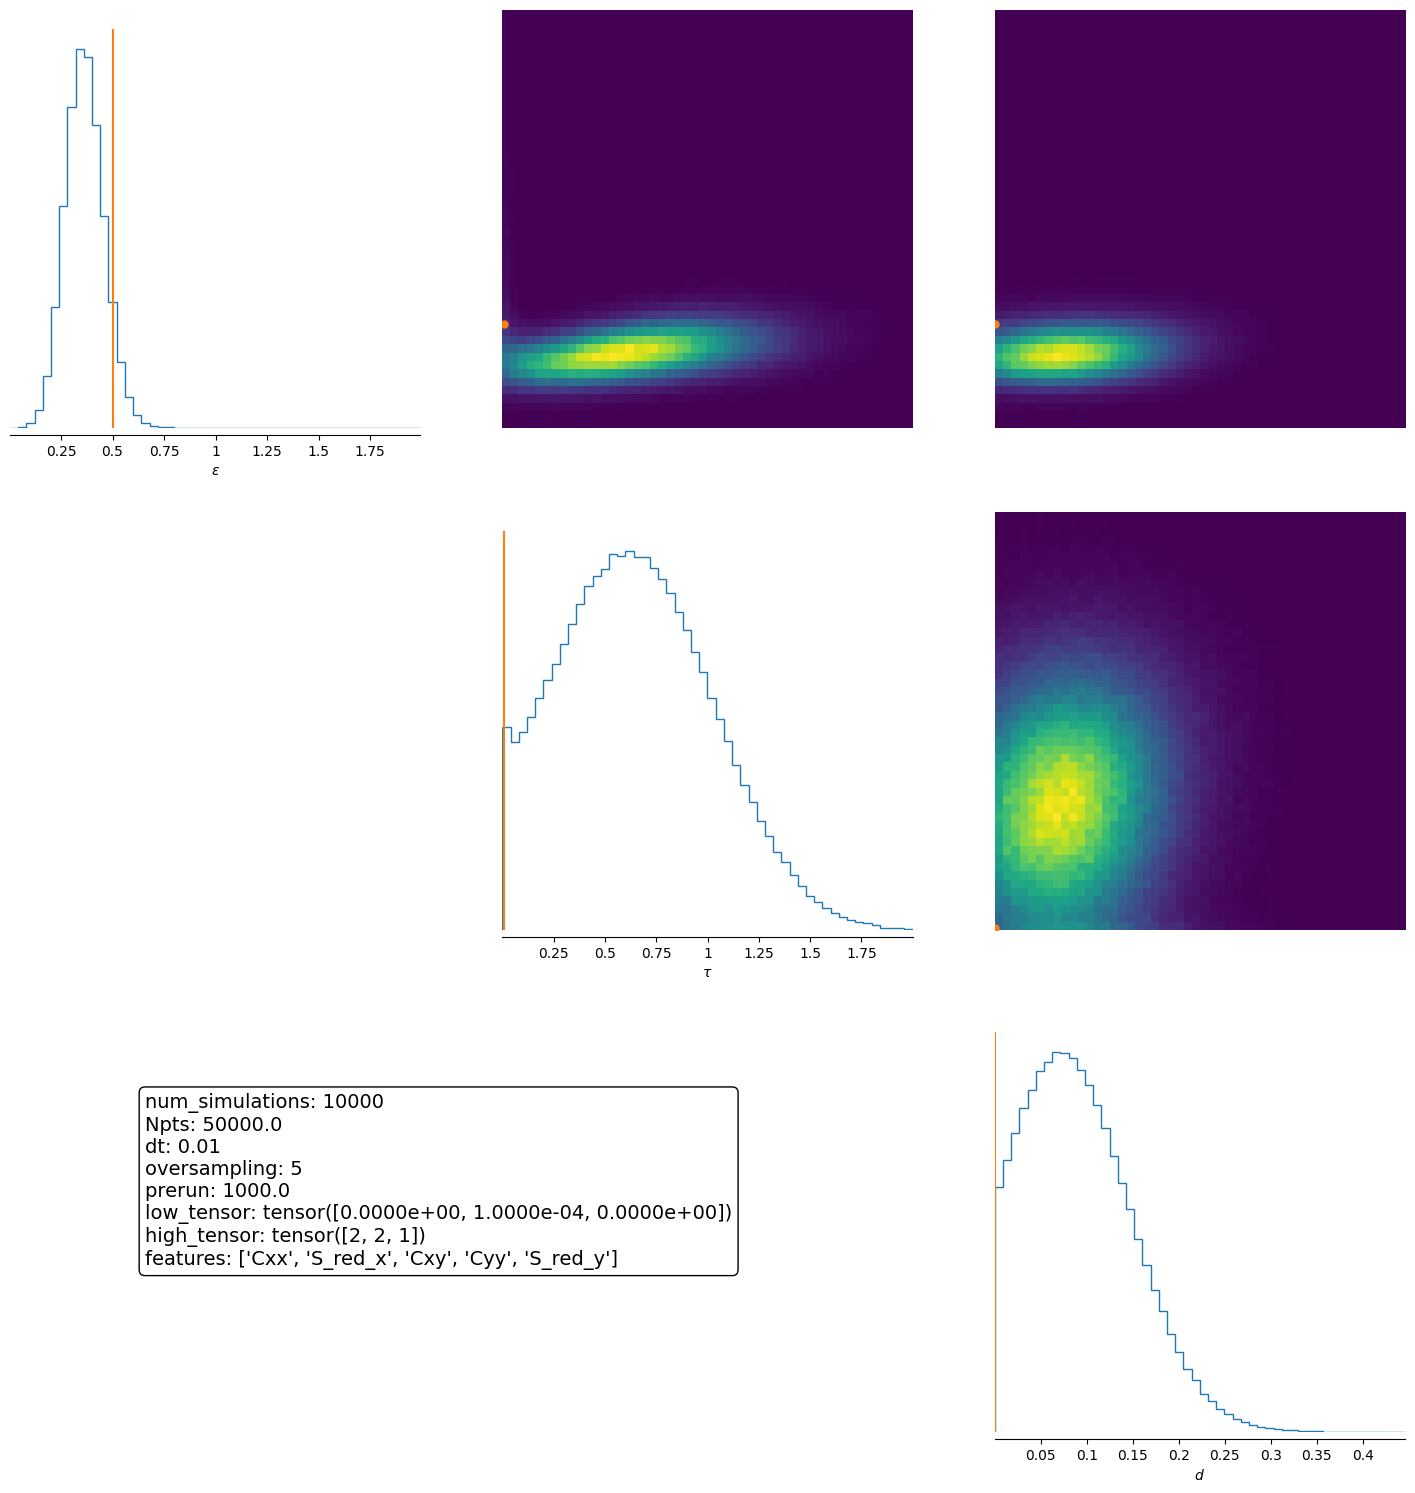

In [13]:
fig,ax = analysis.pairplot(samples, points=theta_true, figsize=(18, 18),labels=[r"$\epsilon$", r"$\tau$", r"$d$"])


# Generate the specs hash
specs_hash_value = specs_hash(specs_dict)

fig_save_dir = 'saved_figures/'
fig_name = f'analysisSNPE_{specs_hash_value}.png'

# Convert metadata dictionary to a string
metadata_text = "\n".join([f"{key}: {value}" for key, value in specs_dict.items()])

# Add text box with metadata
text_box = fig.text(
    0.2, 0.2, metadata_text,
    fontsize=14,
    verticalalignment='bottom',
    horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=1, boxstyle='round,pad=0.3')
)

# Create directory to save dataset if it doesn't exist
if not os.path.isdir(fig_save_dir): os.makedirs(fig_save_dir)
fig_path = os.path.join(fig_save_dir, fig_name)

fig.savefig(fig_path, dpi = 300)

In [16]:
import torch
import itertools
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

# Define the number of points in each dimension
num_points = 10  # Adjust this as needed

# Adjust low_tensor
#low_tensor = low_tensor + 0.01

# Generate linear spaces for each dimension
x_values = torch.linspace(low_tensor[0], high_tensor[0], num_points)
y_values = torch.linspace(low_tensor[1], high_tensor[1], num_points)
z_values = torch.linspace(low_tensor[2], high_tensor[2], num_points)

# Create the grid using itertools.product to get all combinations
grid = torch.tensor(list(itertools.product(x_values, y_values, z_values)))

# Initialize tensor to store the mean parameters
mean_parameters = torch.zeros_like(grid)

# Define number of threads and batch size
n_jobs = 10  # Use all available cores
batch_size = 10  # Adjust this as needed

# Function to process each theta
def process_theta(theta_true):
    # Generate observation
    x_obs, _, _ = simulator_to_sbi_entropy(theta_true)
    
    # Sample from the posterior
    samples = posterior.sample((5000,), x=x_obs, show_progress_bars=False)
    
    # Calculate the mean of the samples
    return samples.mean(dim=0)

# Function to process a batch of thetas
def process_batch(batch):
    return [process_theta(theta_true) for theta_true in batch]

# Split the grid into batches
batches = [grid[i:i + batch_size] for i in range(0, len(grid), batch_size)]

# Use Parallel to process the batches in parallel
results = Parallel(n_jobs=n_jobs)(delayed(process_batch)(batch) for batch in tqdm(batches, desc="Processing batches"))

# Flatten the list of results
results = [item for sublist in results for item in sublist]

# Convert results to a tensor
mean_parameters = torch.stack(results)

# Compute the deviation between the grid and mean_parameters
deviation = grid - mean_parameters

# Print the results
print("Grid:")
print(grid)
print("\nMean Parameters:")
print(mean_parameters)
print("\nDeviation:")
print(deviation)

Processing batches:   0%|          | 0/100 [00:00<?, ?it/s]

Grid:
tensor([[0.0200, 0.0201, 0.0200],
        [0.0200, 0.0201, 0.1289],
        [0.0200, 0.0201, 0.2378],
        ...,
        [2.0000, 2.0000, 0.7822],
        [2.0000, 2.0000, 0.8911],
        [2.0000, 2.0000, 1.0000]])

Mean Parameters:
tensor([[0.2532, 1.3158, 0.0914],
        [0.2156, 1.1092, 0.1636],
        [0.2408, 1.1290, 0.1801],
        ...,
        [1.7882, 1.7269, 0.7834],
        [1.7892, 1.3946, 0.8948],
        [0.9632, 1.0467, 0.9843]])

Deviation:
tensor([[-2.3316e-01, -1.2957e+00, -7.1383e-02],
        [-1.9560e-01, -1.0891e+00, -3.4674e-02],
        [-2.2082e-01, -1.1089e+00,  5.7651e-02],
        ...,
        [ 2.1179e-01,  2.7308e-01, -1.1715e-03],
        [ 2.1083e-01,  6.0536e-01, -3.7243e-03],
        [ 1.0368e+00,  9.5330e-01,  1.5696e-02]])


In [17]:
torch.max(deviation)

tensor(1.2952)

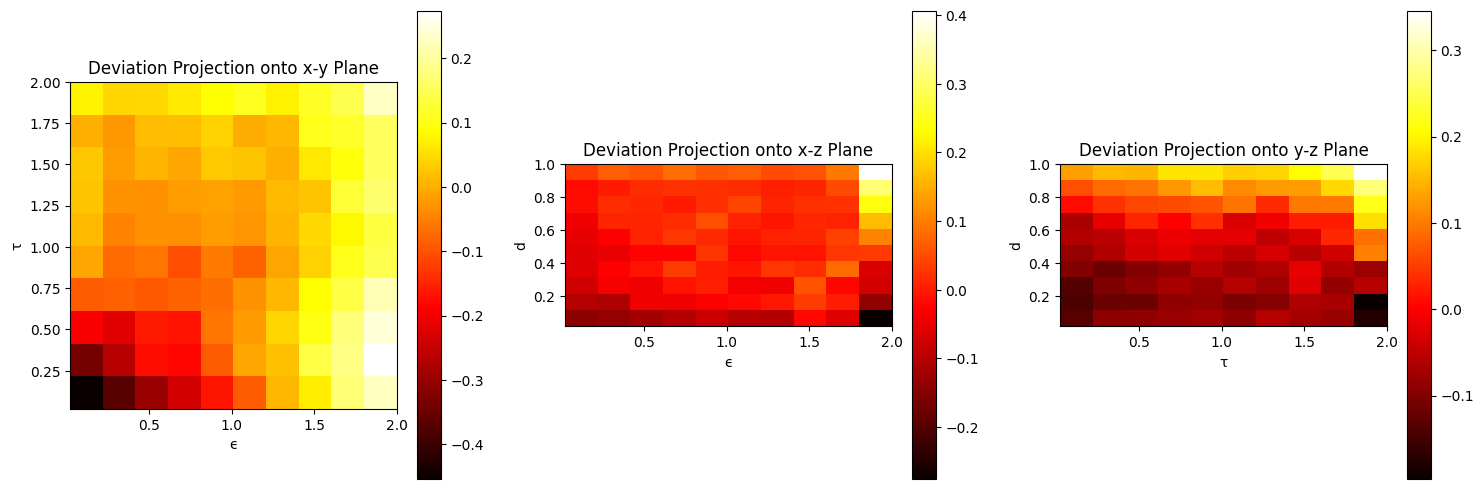

In [19]:
# Reshape deviation tensor for easy slicing
deviation_reshaped = deviation.view(num_points, num_points, num_points, -1)

proj_xy = deviation_reshaped.mean(dim=2).mean(dim=-1)
proj_xz = deviation_reshaped.mean(dim=1).mean(dim=-1)
proj_yz = deviation_reshaped.mean(dim=0).mean(dim=-1)

#proj_xy = deviation_reshaped[:,:,a].mean(dim=-1)
#proj_xz = deviation_reshaped[:,a,:].mean(dim=-1)
#proj_yz = deviation_reshaped[a,:,:].mean(dim=-1)

# Plot the heatmaps
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Heatmap for projection onto x-y plane
cax0 = axes[0].imshow(proj_xy, cmap='hot', interpolation='nearest', origin='lower', extent=[low_tensor[0], high_tensor[0], low_tensor[1], high_tensor[1]])
axes[0].set_title('Deviation Projection onto x-y Plane')
axes[0].set_xlabel('ϵ')
axes[0].set_ylabel('τ')
fig.colorbar(cax0, ax=axes[0])

# Heatmap for projection onto x-z plane
cax1 = axes[1].imshow(proj_xz, cmap='hot', interpolation='nearest', origin='lower', extent=[low_tensor[0], high_tensor[0], low_tensor[2], high_tensor[2]])
axes[1].set_title('Deviation Projection onto x-z Plane')
axes[1].set_xlabel('ϵ')
axes[1].set_ylabel('d')
fig.colorbar(cax1, ax=axes[1])

# Heatmap for projection onto y-z plane
cax2 = axes[2].imshow(proj_yz, cmap='hot', interpolation='nearest', origin='lower', extent=[low_tensor[1], high_tensor[1], low_tensor[2], high_tensor[2]])
axes[2].set_title('Deviation Projection onto y-z Plane')
axes[2].set_xlabel('τ')
axes[2].set_ylabel('d')
fig.colorbar(cax2, ax=axes[2])

plt.tight_layout()
plt.show()

#### Relative deviation

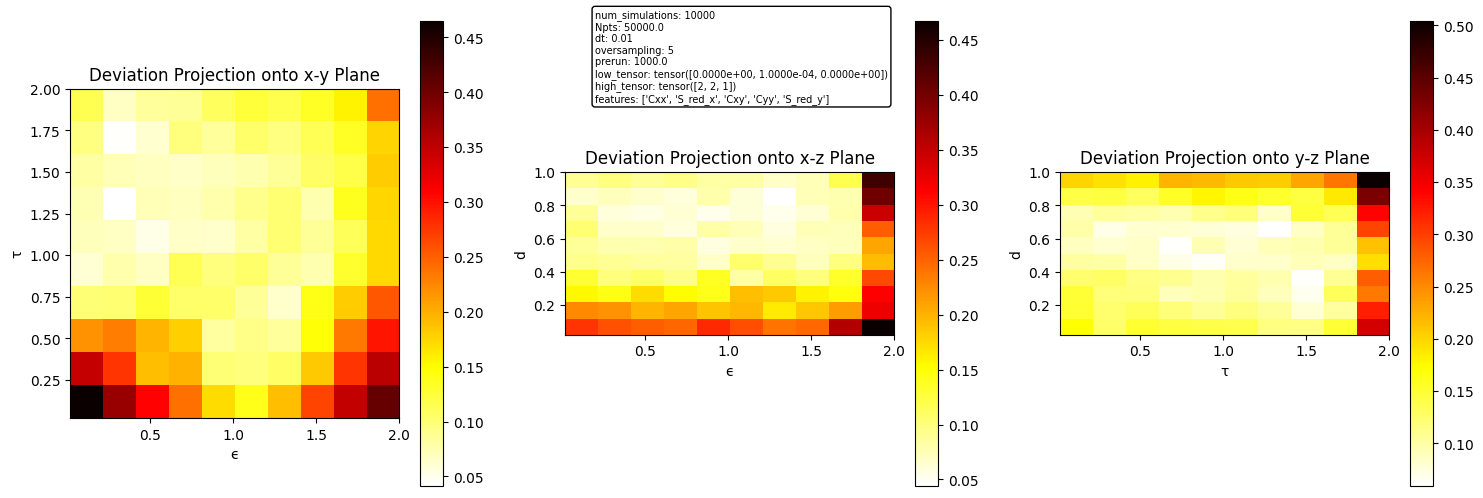

In [33]:
# Reshape deviation tensor for easy slicing
deviation_reshaped = deviation.view(num_points, num_points, num_points, -1)

deviation_reshaped =torch.abs(deviation_reshaped)

proj_xy = deviation_reshaped.mean(dim=2).mean(dim=-1)
proj_xz = deviation_reshaped.mean(dim=1).mean(dim=-1)
proj_yz = deviation_reshaped.mean(dim=0).mean(dim=-1)

# Plot the heatmaps
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Heatmap for projection onto x-y plane
cax0 = axes[0].imshow(proj_xy, cmap='hot_r', interpolation='nearest', origin='lower', extent=[low_tensor[0], high_tensor[0], low_tensor[1], high_tensor[1]])
axes[0].set_title('Deviation Projection onto x-y Plane')
axes[0].set_xlabel('ϵ')
axes[0].set_ylabel('τ')
fig.colorbar(cax0, ax=axes[0])

# Heatmap for projection onto x-z plane
cax1 = axes[1].imshow(proj_xz, cmap='hot_r', interpolation='nearest', origin='lower', extent=[low_tensor[0], high_tensor[0], low_tensor[2], high_tensor[2]])
axes[1].set_title('Deviation Projection onto x-z Plane')
axes[1].set_xlabel('ϵ')
axes[1].set_ylabel('d')
fig.colorbar(cax1, ax=axes[1])

# Heatmap for projection onto y-z plane
cax2 = axes[2].imshow(proj_yz, cmap='hot_r', interpolation='nearest', origin='lower', extent=[low_tensor[1], high_tensor[1], low_tensor[2], high_tensor[2]])
axes[2].set_title('Deviation Projection onto y-z Plane')
axes[2].set_xlabel('τ')
axes[2].set_ylabel('d')
fig.colorbar(cax2, ax=axes[2])

# Convert metadata dictionary to a string
metadata_text = "\n".join([f"{key}: {value}" for key, value in specs_dict.items()])

# Add text box with metadata
text_box = fig.text(
    0.4, 0.8, metadata_text,
    fontsize=7,
    verticalalignment='bottom',
    horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=1, boxstyle='round,pad=0.3')
)



plt.tight_layout()
plt.show()

fig.savefig('heatmap1.png', dpi = 1000)